# Decision tree


#### Import and clean data 

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score

from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from IPython.display import display
from data_processing import prepare_data, split_data
from helper_functions import get_metrics

from oversampling import smote_loop
from data_processing import one_hot_encode

In [2]:
# Clean the data
# Do not normalize the data as we need non-normalized data to be able to interpret it
data = prepare_data('healthcare-dataset-stroke-data.csv', normalize = False, binary = False, one_hot = True)

# Split the data into training, testing and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

display(train_data.head())

,age,avg_glucose_level,bmi,female,male,hypertension,normal,healthy,heart_disease,no,...,never_worked,private,self-employed,children,rural,urban,unknown_smoking_status,formerly_smoked,never_smoked,smokes
1921,44.0,95.46,31.4,0,1,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,1
722,9.0,121.80,18.7,0,1,0,1,1,0,1,...,0,0,0,1,1,0,1,0,0,0
4805,37.0,95.08,34.1,1,0,0,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
4091,27.0,65.43,27.2,1,0,0,1,1,0,1,...,0,0,0,0,1,0,1,0,0,0
1237,33.0,76.66,24.8,1,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0


### Basic model

In [3]:
def train_and_predict(model, training_data, training_labels, testing_data):
    """
    This function trains an instance of the model based on input training data and training labels. 
    It returns the predicted labels for the training_data and the testing_data in a tuple.
    """
    # Fit the data to the model
    model.fit(training_data, training_labels)
    
    # Predict labels for training and testing data
    train_predict = model.predict(training_data)
    test_predict = model.predict(testing_data)
    
    # Return predictions over the training (to test model accuracy for learned data) and testing data
    return train_predict, test_predict

# Make an instance of the DecisionTreeClassifier with default values set
tree = DecisionTreeClassifier(min_samples_split = 2, max_depth = 500)

# Get the predictions
prediction_train, prediction_test = train_and_predict(tree, train_data, train_labels, test_data)

# Print the accuracies using our general imported get_metrics function
print("For the training data:")
train_acc, train_balacc = get_metrics(train_labels, prediction_train, verbose = True)

print("For the testing data")
test_acc, testbalacc = get_metrics(test_labels, prediction_test, verbose = True)

For the training data:
accuracy: 100.0000 %
balanced accuracy: 100.0000 %
sensitivity: 1.0000
specificity: 1.0000 

confusion matrix: 
[[2916    0]
 [   0  149]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

For the testing data
accuracy: 92.8571 %
balanced accuracy: 58.3025 %
sensitivity: 0.2000
specificity: 0.9660 

confusion matrix: 
[[939  33]
 [ 40  10]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Parameter optimization options
There are multiple ways to optimize a decision tree. We will look at:
1. Early stopping &rarr; where to stop
2. Pruning &rarr; cutting leafs

#### Option 1: Early stopping

Make sure the tree is less deep, by using a minimum number of samples that must be present to split the leaf or by giving a maximum tree depth to the algorithm. First we try to find the best minimum number of samples. 

In [4]:
def plot_accuracy(x, training_acc, val_acc, title, x_lab, y_lab = 'accuracy'):
    """
    Plot a list of values, x, and plots a list of training (training_acc) and validation accuracies (val_acc). Lists should be
    the same length. X-labels and titles should be given; there is the option of setting a custom y-label.
    """
    # Plot validation and training accuracy in same plot
    plt.plot(x, training_acc, 'b')
    plt.plot(x, val_acc, 'r')
    
    # Give x and y labels and title
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.title(title)
    
    # Label the lines for training and validation accuracy
    plt.legend(['train accuracy', 'validation accuracy'])
    
    # Set an ylim so accuracy is always shown from 0 to 1
    plt.ylim([0, 1.1])
    
    plt.show()

In [5]:
def try_upgrade(x_min, x_max, x_step, data, titles, x_label, model = DecisionTreeClassifier, upgrade = "min_samples_split"):
    ''' 
    This function tries different values (x) for model parameters (upgrade) and plot the accuracies for the different values 
    and returns the value with the highest balanced accuracy and what that accuracy was.
    
    INPUT: 
    
    x_min, x_max, x_step:   Float, minimum and maximum values and step size for the various values of x.
    data:                   A tuple containing training data, training labels, validation data and validation labels.
    titles:                 List with 2 items:
                            - first the title of the plot that plots accuracy, 
                            - second the title of the plot that plots balanced accuracy
    model:                  Object, type of classifier to use. 
                            Options:
                            - DecisionTreeClassifier (default)
                            - RandomForestClassifier
    upgrade:                String, parameter of the model, for example 'min_samples_split' for the DecisionTree
    

    OUTPUT:
    
    best_x:                 Parameter value for which highest balanced accuracy was found
    high_val:               Balanced accuracy of validation data using optimal parameter
    '''
    
    # Unpack data
    training_data, training_labels, vali_data, vali_labels = data
    
    # Create a range for different values for the model parameter
    x = np.arange(x_min, x_max, x_step)

    # The accuracy for the various values for the model parameter will be appended to these lists
    training_accuracy = []
    vali_accuracy = []
    training_accuracy_balanced = []
    vali_accuracy_balanced = []

    # Loop over all parameter values
    for value in x:
            
        # Make a dictionary out of the parameter we upgrade and the value we use in this split
        dictionary = {upgrade: value}
        
        #  Check if the given upgrade is class_weights
        if upgrade == 'class_weight':
            
            # Replace the dictionary with a different dictionary defining the class weights
            dictionary = {upgrade: {0:1, 1:value}}
                
        # Unpack the values for the model parameter from the dictionary and set these as model parameters for out model
        tree = model(**dictionary)
        
        # Use the train_and_predict function to fit data to the model and predict the labels using the model
        training_predict, vali_predict = train_and_predict(tree, training_data, training_labels, vali_data)

        # Get accuracy for training and validation data
        train_acc, train_bal_acc = get_metrics(train_labels, training_predict)
        val_acc, val_bal_acc = get_metrics(vali_labels, vali_predict)

        # Append the accuracies to the lists
        training_accuracy.append(train_acc)
        training_accuracy_balanced.append(train_bal_acc)
        vali_accuracy.append(val_acc)
        vali_accuracy_balanced.append(val_bal_acc)
    
    # Plot the findings
    plot_accuracy(x, training_accuracy, vali_accuracy, titles[0], x_label)
    plot_accuracy(x, training_accuracy_balanced, vali_accuracy_balanced, 
                  titles[1], x_label, 'balanced accuracy')
    
   
    # Find the best value that has the maximum balanced validation accuracy
    index_max = np.argmax(vali_accuracy_balanced)
    best_x = x[index_max]
    high_val = vali_accuracy_balanced[index_max]
    
    return best_x, high_val

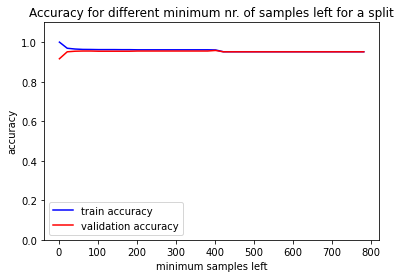

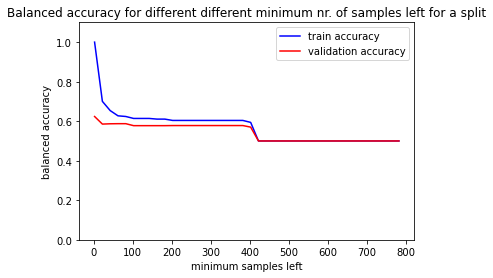

best split size: 2
highest validation accuracy: 0.6237654320987654


In [6]:
# Data we will be giving to this function as a tuple
data_model = (train_data, train_labels, val_data, val_labels)

# Titles for the plots
titles = ["Accuracy for different minimum nr. of samples left for a split", 
          "Balanced accuracy for different different minimum nr. of samples left for a split"]

# Set the range for the split size between 2 and 700, as we have a large dataset
best_split, validation = try_upgrade(2, 800, 20, data_model, titles, 'minimum samples left', upgrade = 'min_samples_split')

print(f'best split size: {best_split}')
print(f'highest validation accuracy: {validation}')

This shows that 2 is the best split size for the balanced accuracy for the validation data, which is a bit odd as this is basically where the model is still overfitting quite a lot. There's also a dip in accuracy around 400 samples per split, as this probably limits the depth of the tree too much.

Then we look for the best tree depth.

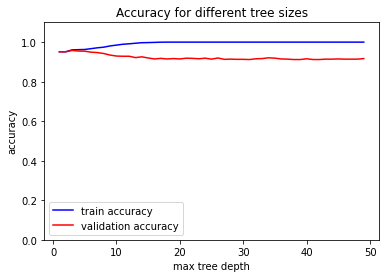

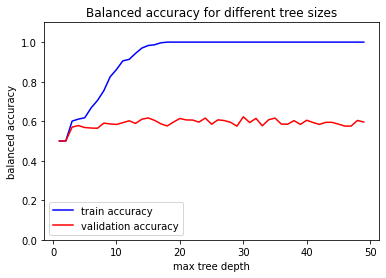

best tree size: 30
highest validation accuracy: 0.6222222222222222

To maximize the tree depth it is best to give a min_split_size of 2 or a max_depth of 30 to the decision tree


In [7]:
# Titles for best tree depth
titles = ['Accuracy for different tree sizes', 'Balanced accuracy for different tree sizes']

# Plot the accuracies of the trees with a maximum depth between 1 and 50
best_depth, validation_size = try_upgrade(1, 50, 1, data_model, titles, 'max tree depth', upgrade = 'max_depth')

print(f'best tree size: {best_depth}')
print(f'highest validation accuracy: {validation_size}\n')

print(f'To maximize the tree depth it is best to give a min_split_size of {best_split} or a max_depth of ' 
      f'{best_depth} to the decision tree')

Normally, it is not necessary to give both optimized values to a decision tree, because this will create a tree with too little depth, since both parameters are restrictions for the tree depth. However, our minimum split size is 2, which does not limit the tree depth at all, so we could try to apply both and see the accuracies of these values on the testing data:

In [8]:
# Use optimal values for the tree
tree = DecisionTreeClassifier(min_samples_split = best_split, max_depth = best_depth)

# Get the predictions
prediction_train, prediction_test = train_and_predict(tree, train_data, train_labels, test_data)

# Print the accuracies
print("For the training data:")
train_acc, train_balacc = get_metrics(train_labels, prediction_train, verbose = True)

print("For the testing data")
test_acc, testbalacc = get_metrics(test_labels, prediction_test, verbose = True)

For the training data:
accuracy: 100.0000 %
balanced accuracy: 100.0000 %
sensitivity: 1.0000
specificity: 1.0000 

confusion matrix: 
[[2916    0]
 [   0  149]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

For the testing data
accuracy: 92.4658 %
balanced accuracy: 57.1481 %
sensitivity: 0.1800
specificity: 0.9630 

confusion matrix: 
[[936  36]
 [ 41   9]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Option 2: pruning

Number of nodes in the last tree is: 1 with ccp_alpha: 0.006888599274786439


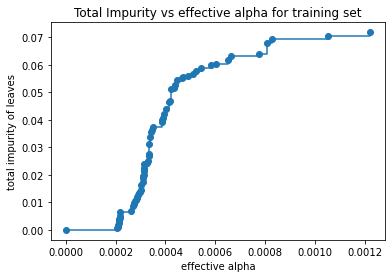

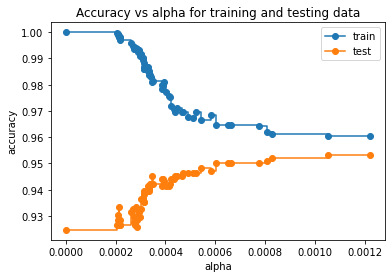

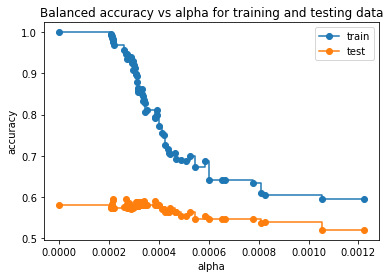

The best alpha is 0.00021 leading to a balanced accuracy of 0.59508.The tree then has a depth of 18 and 365 nodes.


In [9]:
"""
Code from: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
"""

# Create a decision tree
tree = DecisionTreeClassifier(random_state=0)

# Compute the cost complexity parameter (ccp_alpha)
# Greater ccp_alpha means more nodes are pruned and impurities is information about how pure the nodes are
path = tree.cost_complexity_pruning_path(train_data, train_labels)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the cost complexity parameter and the impurities for all trees but the one with only one node
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# Create an empty list to save trees
trees = []

# Loop over all used cost complexity parameters 
for ccp_alpha in ccp_alphas:
    
    # Create a decision tree using this alpha
    tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    
    # Fit the tree on the data
    tree.fit(train_data, train_labels)
    
    # Add the tree to the list
    trees.append(tree)
    
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(trees[-1].tree_.node_count, ccp_alphas[-1]))

# Remove the tree without splits from the list with trees and the list with alpha's 
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

# Create empty list to save the normal accuracy and the balanced accuracy for both training and testing data
train_scores = []
test_scores = []
train_scores_balanced = []
test_scores_balanced = []

# Loop over all the trees
for tree in trees:
    
    # Get the predicted labels from the tree
    train_predict = tree.predict(train_data)
    test_predict = tree.predict(test_data)
    
    # Compute the accuracy and balanced accuracy
    train_accuracy, train_balanced = get_metrics(train_labels, train_predict)
    test_accuracy, test_balanced = get_metrics(test_labels, test_predict)
    
    # Add values to the correct list
    train_scores_balanced.append(train_balanced)
    train_scores.append(train_accuracy)
    test_scores_balanced.append(test_balanced)
    test_scores.append(test_accuracy)
    
# Plot the accuracies of the training and testing data with the cost complexity parameter
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing data")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

# Plot the balanced accuracies of the training and testing data with the cost complexity parameter
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Balanced accuracy vs alpha for training and testing data")
ax.plot(ccp_alphas, train_scores_balanced, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_balanced, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

# Find the best alpha and tree by getting the maximum balanced validation accuracy
index_max = np.argmax(test_scores_balanced)
best_alpha = ccp_alphas[index_max]
high_balanced = test_scores_balanced[index_max]
best_tree = trees[index_max]

print(f'The best alpha is {best_alpha:.5f} leading to a balanced accuracy of {high_balanced:.5f}.'
      f'The tree then has a depth of {best_tree.tree_.max_depth} and {best_tree.tree_.node_count} nodes.')

Let's see how well this alpha does on the testing data.

In [10]:
# Use the best alpha for this tree
alpha_tree = DecisionTreeClassifier(ccp_alpha = best_alpha)

# Get the predictions
prediction_train_pruned, prediction_test_pruned = train_and_predict(alpha_tree, train_data, train_labels, test_data)

# Print the accuracies
print("For the training data:")
train_accuracy, train_balaccuracy = get_metrics(train_labels, prediction_train_pruned, verbose = True)

print("For the testing data")
test_accuracy, test_balaccuracy = get_metrics(test_labels, prediction_test_pruned, verbose = True)

For the training data:
accuracy: 99.8369 %
balanced accuracy: 98.3221 %
sensitivity: 0.9664
specificity: 1.0000 

confusion matrix: 
[[2916    0]
 [   5  144]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

For the testing data
accuracy: 92.9550 %
balanced accuracy: 58.3539 %
sensitivity: 0.2000
specificity: 0.9671 

confusion matrix: 
[[940  32]
 [ 40  10]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Class weights
Considering our data is very unbalanced it might also help to give the stroke class a higher weight. This would cause the entropy to be more dependent on the stroke data. It is easy to add this to the decision tree, using class_weight. 

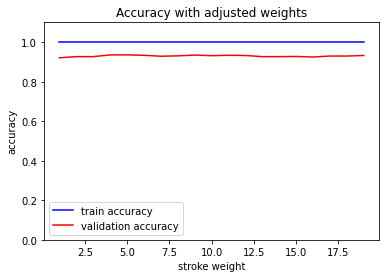

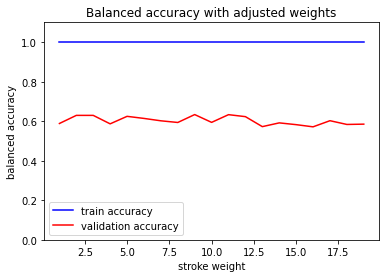

best stroke weight: 9
highest validation accuracy: 0.6335390946502057


In [11]:
# Create a list with titles to plot the accuracies for different class weights
titles = ['Accuracy with adjusted weights', 'Balanced accuracy with adjusted weights']

# Try a range of weights for the stroke class between 1 and 20 and plot the accuracies
best_weight, val_score = try_upgrade(1, 20, 1, data_model, titles, 'stroke weight', model = DecisionTreeClassifier, 
                                     upgrade="class_weight")

print(f'best stroke weight: {best_weight}')
print(f'highest validation accuracy: {val_score}')

The weight of the stroke class seems to be varying between around 3 to 10. Let's see what the stroke weight does for the testing data.

In [12]:
# Give a dictionary of class weights to the function, with the non-stroke class at a weight of 0
# and the stroke class at the weight of the best_weight
weight_tree = DecisionTreeClassifier(class_weight = {0:1, 1: best_weight})

# Get the predictions
prediction_train_pruned, prediction_test_pruned = train_and_predict(weight_tree, train_data, train_labels, test_data)

# Print the accuracies
print("For the training data:")
train_accuracy, train_balaccuracy = get_metrics(train_labels, prediction_train_pruned, verbose = True)

print("For the testing data")
test_accuracy, test_balaccuracy = get_metrics(test_labels, prediction_test_pruned, verbose = True)

For the training data:
accuracy: 100.0000 %
balanced accuracy: 100.0000 %
sensitivity: 1.0000
specificity: 1.0000 

confusion matrix: 
[[2916    0]
 [   0  149]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

For the testing data
accuracy: 92.2701 %
balanced accuracy: 57.0453 %
sensitivity: 0.1800
specificity: 0.9609 

confusion matrix: 
[[934  38]
 [ 41   9]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



Let's now plot the first few branches of the decision tree , to see which factors are important for classifying stroke from non-stroke patients.

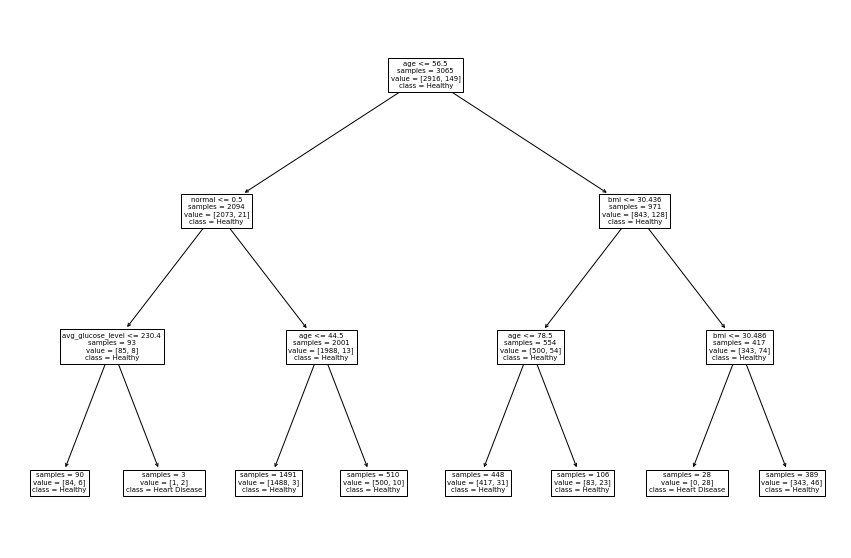

In [13]:
# Import this here because we use tree as a model name a few times as well 
from sklearn import tree

# Plot root of decision tree using this optimal split size, to see what this shows us about important features
# Set max depth to 3, as the plot is unreadable otherwise.
d_tree = DecisionTreeClassifier(max_depth = 3, min_samples_split = best_split)
d_tree.fit(train_data, train_labels)

figure(figsize=(15, 10))
tree.plot_tree(d_tree, feature_names=data.columns.values, class_names=['Healthy', 'Heart Disease'], impurity=False);

# Random forest
Try a normal random forest, to see if many trees are better at predicting strokes as opposed to one tree. Try different ratios of training data that each tree in the forest in trained on first, to find the optimal value.

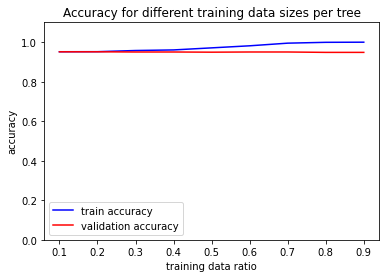

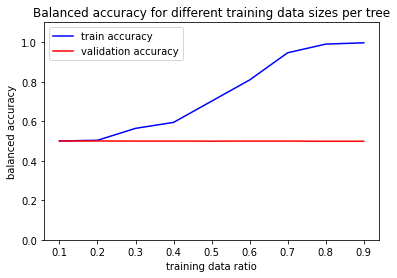

best training data ratio: 0.1
highest validation accuracy: 0.5


In [14]:
# Create a list with titles for the figures 
titles = ['Accuracy for different training data sizes per tree', 'Balanced accuracy for different training data sizes per tree' ]

# Get accuracies for the various amount of the data we train the model on
ratio, validation_acc = try_upgrade(0.1, 1, 0.1, data_model, titles, 'training data ratio', model = RandomForestClassifier,
                                    upgrade = 'max_samples')

print(f'best training data ratio: {ratio}')
print(f'highest validation accuracy: {validation_acc}')

In [15]:
# Get the accuracies on the testing data using the optimal ratio & the best weight we found for individual trees
model = RandomForestClassifier(max_samples = ratio, class_weight = {0:1, 1:best_weight}, max_features = None)
train_prediction, test_prediction = train_and_predict(model, train_data, train_labels, test_data)

# Print the accuracies
print("For the training data:")
train_acc, train_balacc = get_metrics(train_labels, train_prediction, verbose = True)

print("For the testing data:")
test_acc, testbalacc = get_metrics(test_labels, test_prediction, verbose = True)

For the training data:
accuracy: 95.1713 %
balanced accuracy: 50.3356 %
sensitivity: 0.0067
specificity: 1.0000 

confusion matrix: 
[[2916    0]
 [ 148    1]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

For the testing data:
accuracy: 95.1076 %
balanced accuracy: 50.0000 %
sensitivity: 0.0000
specificity: 1.0000 

confusion matrix: 
[[972   0]
 [ 50   0]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



### Resampled forest
Normal random forests seems to work even worse than a single tree, as the random forest just classsifies everything as non-stroke. So we will try to train some trees using all the stroke data for every tree and only part of the total dataset; hopefully, this counteracts the imbalance between output classes in the dataset and makes it easier for the model to train.

In [16]:
def resampled_forest(data, nr_splits):
    """
    This function makes a forest of Classifiers, each trained on all of the data of patients with strokes and only part of the 
    sample of patients without strokes. 
    
    INPUT: 
    
    data:       Tuple with 4 data items in order: training_data, training_labels, testing_data, testing_labels.
    nr_splits:  Determines determines how many times the non-stroke data is split; also determines the amount of trees
                in the forest.
    
    OUTPUT:
    
    train_predictions,   The final predictions of the forest for both training and testing data, determined by majority vote. 
    test_predictions:
    """
    # Unpack data
    training_data, training_labels, testing_data, testing_labels = data
    
    # Seperate data from patients with stroke from no stroke by making a mask based on the labels 
    stroke_mask = training_labels == 1
    stroke_data = training_data[stroke_mask]

    # This selects the opposite of the mask, to get patients without stroke
    non_stroke_data = training_data[~stroke_mask]
    
    # Get variables to sum to later
    train_predicted = 0
    test_predicted = 0

    # Get the ratio that we will have to use for sampling the dataset for nr_splits amount of splits
    ratio = 1 / nr_splits

    # For the amount of splits, sample a new part of the data and train a new decision tree on it
    for split in range(nr_splits):

        # Get a sample of the non-stroke data
        sample_non_stroke = non_stroke_data.sample(frac = ratio)

        # Remove this sample from the dataset so we eventually use all the data to train our forest of trees
        non_stroke_data.drop(sample_non_stroke.index)

        # Append the non-stroke sample and our data for stroke patients to actually train the tree on
        mini_train = pd.concat((sample_non_stroke, stroke_data))

        # Get the labels belonging to this mini-train set
        mini_train_labels = training_labels[mini_train.index]

        # Make an instance of a DecisionTree
        model = DecisionTreeClassifier()

        # Train our model on the mini-trainingset 
        model.fit(mini_train, mini_train_labels)

        # Predict labels for entire training data and testing data with this model
        train_predict = model.predict(training_data)
        test_predict = model.predict(testing_data)

        # Add the predicted scores for this model to the total scores over all trees
        train_predicted += train_predict
        test_predicted += test_predict

        # Calculate if the majority of the trees classified the training and testing sample as stroke or not
        train_predictions = train_predicted / nr_splits >= 0.5
        test_predictions = test_predicted / nr_splits >= 0.5

    #  Return the predictions
    return train_predictions, test_predictions 

For determining the optimal amount of datasplits, we will plot the accuracies for different number of datasplits.

In [17]:
def try_splits(data, split_list):
    """
    This function tries different splits for resampled_forest and returns accuracies for these splits.
    
    INPUT
    data:         A tuple of training data, training labels, validation data, validation labels.
    split_list:   A list of integers to try to split the data on.
    
    OUTPUT
    A tuple of training accuracy, validation accuracy, balanced training accuracy and balanced validation accuracy.
    
    """
    training_data, training_labels, val_data, val_labels = data
    # Create empty lists to save accuracies
    training_accuracy = []
    vali_accuracy = []
    bal_train_accuracy = []
    val_bal_accuracy = []

    # Loop over every split
    for splits in split_list:
    
        # Get the predictions for the training and validation data for this number of splits
        training_predictions, val_predictions = resampled_forest(data, splits)

        # Get accuracy for training and validation data
        train_acc, train_bal_acc = get_metrics(training_labels, training_predictions)
        val_acc, val_bal_acc = get_metrics(val_labels, val_predictions)

        # Append the accuracies to the lists
        training_accuracy.append(train_acc)
        bal_train_accuracy.append(train_bal_acc)
        vali_accuracy.append(val_acc)
        val_bal_accuracy.append(val_bal_acc)
    
    return training_accuracy, vali_accuracy, bal_train_accuracy, val_bal_accuracy

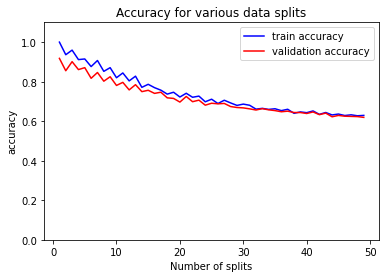

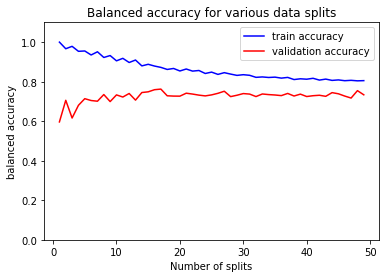

best split_size: 17
highest validation accuracy: 0.7624279835390947


In [18]:
# Get a range of splits between 1 and 50.
splits_range = np.arange(1, 50, 1)

train_accuracy, validation_accuracy, bal_train_acc, val_bal_acc = try_splits(data_model, splits_range)
    
# Plot the findings with the plot_accuracy function
plot_accuracy(splits_range, train_accuracy, validation_accuracy, 'Accuracy for various data splits', 'Number of splits')
plot_accuracy(splits_range, bal_train_acc, val_bal_acc, 
              'Balanced accuracy for various data splits', 'Number of splits', 'balanced accuracy')

# Find the best split by getting the maximum balanced validation accuracy
index_max = np.argmax(val_bal_acc)
best_split = splits_range[index_max]
high_val = val_bal_acc[index_max]


print(f'best split_size: {best_split}')
print(f'highest validation accuracy: {high_val}')

Let's see how well this split size does on the testing data.

In [19]:
# Create a tuple of all data necessary 
test_data = train_data, train_labels, test_data, test_labels

# Train a forest with this best split
training_predictions, test_predictions = resampled_forest(test_data, best_split)

# Print the accuracies
get_metrics(train_labels, training_predictions, verbose = True);
get_metrics(test_labels, test_predictions, verbose = True);

accuracy: 76.8026 %
balanced accuracy: 87.8086 %
sensitivity: 1.0000
specificity: 0.7562 

confusion matrix: 
[[2205  711]
 [   0  149]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

accuracy: 74.9511 %
balanced accuracy: 77.3457 %
sensitivity: 0.8000
specificity: 0.7469 

confusion matrix: 
[[726 246]
 [ 10  40]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



That's pretty good! Let's see we can get it even higher with some oversampled data.

In [20]:
# Load the data without one-hot encoding, as this is needed for the oversampling function
oversampled_data = prepare_data('healthcare-dataset-stroke-data.csv', one_hot = False,
                         binary = False, normalize = False)

# Split the data into training, validation and testing data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(oversampled_data, 
                                                                                    split_size=(0.6, 0.2, 0.2))

# One hot-encode the testing data, as this happens for the oversampled training data in the smote loop
test_data = one_hot_encode(test_data)
val_data = one_hot_encode(val_data)

# Create the oversampled data with its labels and ratios
list_data, list_labels, list_ratio = smote_loop(train_data, train_labels, 0.2, 1.1, 0.2)

Let's try to find the optimal oversampling ratio for our dataset.

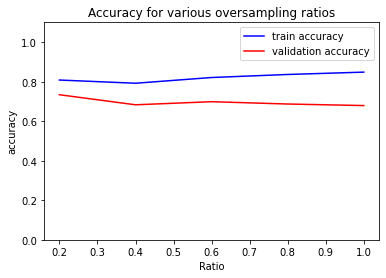

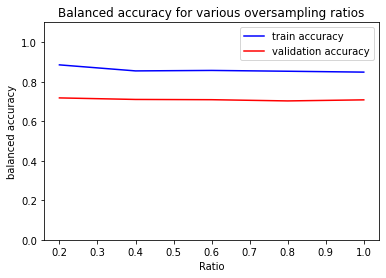

best oversampling ratio: 0.2
highest validation accuracy: 0.717798353909465


In [21]:
# Make instances of list to append to
training_accuracy = []
vali_accuracy = []
training_accuracy_balanced = []
vali_accuracy_balanced = []

# Loop over all different ratios of oversampled datasets and labels
for sampled_data, sampled_labels in zip(list_data, list_labels):
    
    # Create a tuple of all data necessary, wih the training data and labels with a certain ratio of oversampling
    data = sampled_data, sampled_labels, val_data, val_labels

    # Train a forest with a split at 10
    training_predictions, test_predictions = resampled_forest(data, 10)
    
    # Get the accuracies
    train_acc, train_bal_acc = get_metrics(sampled_labels, training_predictions)
    val_acc, val_bal_acc = get_metrics(val_labels, test_predictions)
    
    # Append the accuracies to the lists
    training_accuracy.append(train_acc)
    training_accuracy_balanced.append(train_bal_acc)
    vali_accuracy.append(val_acc)
    vali_accuracy_balanced.append(val_bal_acc)
    

# Plot the findings with the plot_accuracy function
plot_accuracy(list_ratio, training_accuracy, vali_accuracy, 'Accuracy for various oversampling ratios', 'Ratio')
plot_accuracy(list_ratio, training_accuracy_balanced, vali_accuracy_balanced, 
              'Balanced accuracy for various oversampling ratios', 'Ratio', 'balanced accuracy')

# Find the best split by getting the maximum balanced validation accuracy
index_max = np.argmax(vali_accuracy_balanced)
best_ratio = list_ratio[index_max]
high_val = vali_accuracy_balanced[index_max]


print(f'best oversampling ratio: {best_ratio}')
print(f'highest validation accuracy: {high_val}')

Let's try this best oversampling ratio on the testing data to see what kind of accuracies we can get.

In [22]:
# Get the dataset that belongs to the optimal oversampling ratio using index_max
data = list_data[index_max], list_labels[index_max], test_data, test_labels

# Train a forest with a randomly chosen split of 10 but on the best oversampling ratio
training_predictions, test_predictions = resampled_forest(data, 10)

# Print the accuracies
get_metrics(list_labels[index_max], training_predictions, verbose = True);
get_metrics(test_labels, test_predictions, verbose = True);

accuracy: 79.7371 %
balanced accuracy: 87.8429 %
sensitivity: 1.0000
specificity: 0.7569 

confusion matrix: 
[[2207  709]
 [   0  583]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

accuracy: 73.5812 %
balanced accuracy: 77.5741 %
sensitivity: 0.8200
specificity: 0.7315 

confusion matrix: 
[[711 261]
 [  9  41]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



Accuracy does not really seem to be higher with oversampling and the rebalanced forest; there are a lot of false positives, which show that the model expects a lot more strokes than there are in reality, which is not that weird. We can try to fit a different split/tree number for the rebalanced forest in combination with the best oversampling ratio.

In [23]:
# Get a range of splits between 1 and 20
splits_range = np.arange(1, 20, 1)

# Get lengths of the variable lists for the output matrix dimensions
length_splits = len(splits_range)
length_ratios = len(list_labels)

# Make the output matrixes
training_accuracy = np.zeros((length_ratios, length_splits))
vali_accuracy = np.zeros((length_ratios, length_splits))
training_accuracy_balanced = np.zeros((length_ratios, length_splits))
vali_accuracy_balanced = np.zeros((length_ratios, length_splits))

# Loop over all different ratios of oversampled datasets and labels
for ratios, (sampled_data, sampled_labels) in enumerate(zip(list_data, list_labels)):
    
    # Create a tuple of all data necessary, wih the training data and labels with a certain ratio of oversampling
    data = (sampled_data, sampled_labels, val_data, val_labels)
    
    # For this ratio of oversampled data, try all the splits in our split range
    train_accuracy, validation_accuracy, bal_train_acc, val_bal_acc = try_splits(data, splits_range)
    
    # Add the accuracies to matrix with accuracies, on the row for this ratio of oversampling
    training_accuracy[ratios, :]  = train_accuracy
    training_accuracy_balanced[ratios, :] = bal_train_acc
    vali_accuracy[ratios, :] = validation_accuracy
    vali_accuracy_balanced[ratios, :] = val_bal_acc
    
# Get the max balanced accuracy index; unravel for argmax to work correctly
# the first index can index the correct ratio, the second index can indicate the optimal split size
bal_acc_max_index = np.unravel_index(vali_accuracy_balanced.argmax(), vali_accuracy_balanced.shape)

# Index the optimal values
optimal_oversample = list_ratio[bal_acc_max_index[0]]
optimal_split = splits_range[bal_acc_max_index[1]]
best_acc = vali_accuracy_balanced[bal_acc_max_index]
print(f"The optimal oversampling ratio is {optimal_oversample} and the optimal split for this is {optimal_split}.")
print(f"This gives a balanced accuracy on the validation data of {best_acc:.3f}.")

The optimal oversampling ratio is 0.2 and the optimal split for this is 11.
This gives a balanced accuracy on the validation data of 0.766.


Looks like we found the optimal values; let's also plot the relationship between these values in a 3D plot.

In [24]:
# Interactive plotting in separate window
%matplotlib qt 

# Make 3D figure
fig = plt.figure(figsize=(10,10))

# Create 3 axes
ax = fig.add_subplot(111, projection='3d')

# Add the two axes with the different splits and the different oversampling ratios 
X0 = splits_range
Y0 = list_ratio

# make a grid, in order to plot every point
X, Y = np.meshgrid(X0, Y0)

# Add the third axis, in this case the validation accuracy
Z = vali_accuracy_balanced 

# Make the plot 
actual_plot = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

# Add a colorbar
fig.colorbar(actual_plot, shrink=0.5, aspect=5)

# Label X and Y and Z and set a title
ax.set_xlabel('Split')
ax.set_ylabel('Oversampling ratio')
ax.set_zlabel('Balanced accuracy');

ax.set_title("Effect of split size and oversampling ratio on balanced accuracy");

Let's try these optimal values on the testing data.

In [25]:
# Get the oversampled data with this best ratio by indexing the data from the list
data = list_data[bal_acc_max_index[0]], list_labels[bal_acc_max_index[0]], test_data, test_labels

# Train a resampled forest with this best split
training_predictions, test_predictions = resampled_forest(data, optimal_split)

# Print the accuracies
get_metrics(list_labels[bal_acc_max_index[0]], training_predictions, verbose = True);
get_metrics(test_labels, test_predictions, verbose = True);

accuracy: 80.8517 %
balanced accuracy: 88.5117 %
sensitivity: 1.0000
specificity: 0.7702 

confusion matrix: 
[[2246  670]
 [   0  583]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

accuracy: 73.5812 %
balanced accuracy: 69.9856 %
sensitivity: 0.6600
specificity: 0.7397 

confusion matrix: 
[[719 253]
 [ 17  33]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



For this run, it seems that oversampling scores worse than just using the resampled_forest. 